
## Prodigy Infotech Task 5
##### Neural Style Transfer


In [1]:
# import numpy, tensorflow and matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

# import VGG 19 model and keras Model API
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

In [2]:
# Image Credits: Tensorflow Doc
content_path = tf.keras.utils.get_file(
'content.jpg',
'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file(
'style.jpg',
'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

195196/195196 [==============================] - 0s 2us/step


In [3]:
# code to load and process image
def load_and_process_image(image_path):
	img = load_img(image_path)
	# convert image to array
	img = img_to_array(img)
	img = preprocess_input(img)
	img = np.expand_dims(img, axis=0)
	return img

In [4]:
# code
def deprocess(img):
	# perform the inverse of the pre processing step
	img[:, :, 0] += 103.939
	img[:, :, 1] += 116.779
	img[:, :, 2] += 123.68
	# convert RGB to BGR
	img = img[:, :, ::-1]

	img = np.clip(img, 0, 255).astype('uint8')
	return img


def display_image(image):
	# remove one dimension if image has 4 dimension
	if len(image.shape) == 4:
		img = np.squeeze(image, axis=0)

	img = deprocess(img)

	plt.grid(False)
	plt.xticks([])
	plt.yticks([])
	plt.imshow(img)
	return

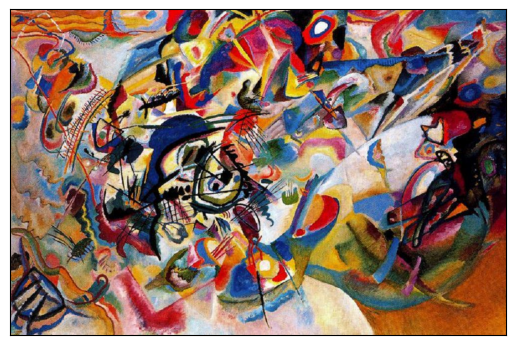

In [5]:
# load content image
content_img = load_and_process_image(content_path)
display_image(content_img)

# load style image
style_img = load_and_process_image(style_path)
display_image(style_img)


In [6]:
# code
# this function download the VGG model and initialise it
model = VGG19(
	include_top=False,
	weights='imagenet'
)
# set training to False
model.trainable = False
# Print details of different layers

model.summary()

80134624/80134624 [==============================] - 43s 1us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                             

In [7]:
# define content model
content_layer = 'block5_conv2'
content_model = Model(
	inputs=model.input,
	outputs=model.get_layer(content_layer).output
)
content_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [8]:
# define style model
style_layers = [
	'block1_conv1',
	'block3_conv1',
	'block5_conv1'
]
style_models = [Model(inputs=model.input,
					outputs=model.get_layer(layer).output) for layer in style_layers]


In [9]:
# Content loss
def content_loss(content, generated):
	a_C = content_model(content)
	a_G = content_model(generated) # Add this line to compute a_G
	loss = tf.reduce_mean(tf.square(a_C - a_G))
	return loss

In [10]:
# gram matrix
def gram_matrix(A):
	channels = int(A.shape[-1])
	a = tf.reshape(A, [-1, channels])
	n = tf.shape(a)[0]
	gram = tf.matmul(a, a, transpose_a=True)
	return gram / tf.cast(n, tf.float32)


weight_of_layer = 1. / len(style_models)

In [11]:
#style loss
def style_cost(style, generated):
	J_style = 0

	for style_model in style_models:
		a_S = style_model(style)
		a_G = style_model(generated)
		GS = gram_matrix(a_S)
		GG = gram_matrix(a_G)
		content_cost = tf.reduce_mean(tf.square(GS - GG))
		J_style += content_cost * weight_of_layer

	return J_style

In [12]:
#content loss
def content_cost(style, generated):
	J_content = 0

	for style_model in style_models:
		a_S = style_model(style)
		a_G = style_model(generated)
		GS = gram_matrix(a_S)
		GG = gram_matrix(a_G)
		content_cost = tf.reduce_mean(tf.square(GS - GG))
		J_content += content_cost * weight_of_layer

	return J_content

In [17]:
import time
import math
import tensorflow as tf

generated_images = []

def training_loop(content_path, style_path, iterations=50, a=10, b=1000):
    # Load content and style images from their respective path
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype=tf.float32)

    opt = tf.keras.optimizers.Adam(learning_rate=7)

    best_cost = math.inf
    best_image = None
    
    for i in range(iterations):
        start_time_cpu = time.process_time()
        start_time_wall = time.time()
        
        with tf.GradientTape() as tape:
            J_content = content_cost(style, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style

        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])

        end_time_cpu = time.process_time()  # Record end time for CPU
        end_time_wall = time.time()  # Record end time for wall time
        
        cpu_time = end_time_cpu - start_time_cpu  # Calculate CPU time
        wall_time = end_time_wall - start_time_wall  # Calculate wall time

        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()

        print("CPU times: user {:.2f} ms, sys: {:.2f} ms, total: {:.2f} ms".format(
            cpu_time * 1000, 
            (end_time_cpu - start_time_cpu) * 1000, 
            (end_time_cpu - start_time_cpu + 1e-6) * 1000)
        )

        print("Wall time: {:.2f} ms".format(wall_time * 1000))
        print("Iteration: {}".format(i))
        print('Total Loss: {:.6e}.'.format(J_total))
        
        generated_images.append(generated.numpy())

    return best_image


In [19]:
final_img = training_loop(content_path, style_path)

CPU times: user 233250.00 ms, sys: 233250.00 ms, total: 233250.00 ms
Wall time: 135675.70 ms
Iteration: 0
Total Loss: 4.582239e+11.
CPU times: user 222812.50 ms, sys: 222812.50 ms, total: 222812.50 ms
Wall time: 128663.92 ms
Iteration: 1
Total Loss: 3.113243e+11.
CPU times: user 215281.25 ms, sys: 215281.25 ms, total: 215281.25 ms
Wall time: 143840.05 ms
Iteration: 2
Total Loss: 1.852609e+11.
CPU times: user 222765.62 ms, sys: 222765.62 ms, total: 222765.63 ms
Wall time: 125534.37 ms
Iteration: 3
Total Loss: 1.519092e+11.
CPU times: user 222671.88 ms, sys: 222671.88 ms, total: 222671.88 ms
Wall time: 125511.36 ms
Iteration: 4
Total Loss: 1.413674e+11.
CPU times: user 219937.50 ms, sys: 219937.50 ms, total: 219937.50 ms
Wall time: 123333.38 ms
Iteration: 5
Total Loss: 1.074964e+11.
CPU times: user 222265.62 ms, sys: 222265.62 ms, total: 222265.63 ms
Wall time: 122594.05 ms
Iteration: 6
Total Loss: 7.990615e+10.
CPU times: user 221968.75 ms, sys: 221968.75 ms, total: 221968.75 ms
Wall ti

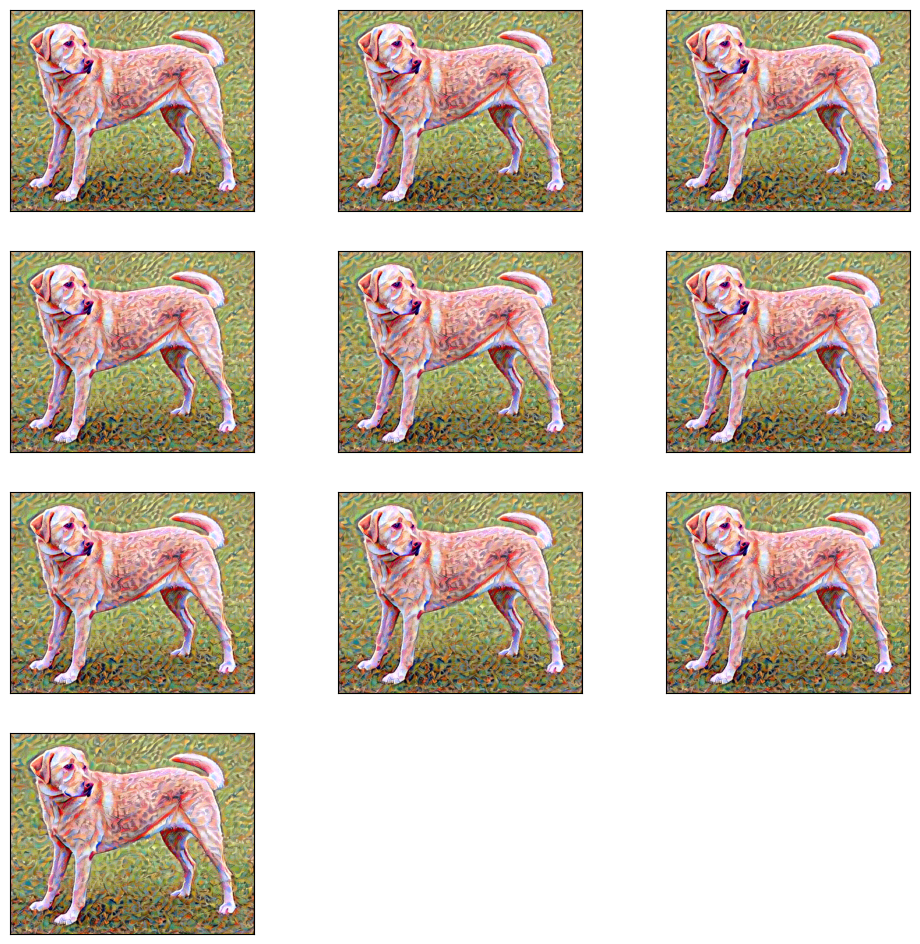

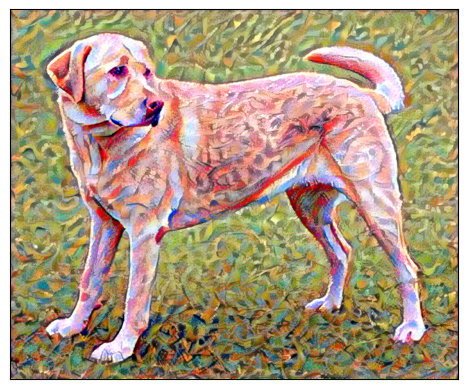

In [20]:
# code to display best generated image and last 10 intermediate results
plt.figure(figsize=(12, 12))

for i in range(10):
	plt.subplot(4, 3, i + 1)
	display_image(generated_images[i+39])
plt.show()

# plot best result
display_image(final_img)